# Astronomy 8824 - Problem Set 4
The goal of this problem set is to gain familiarity with multivariate Gaussians and Markov Chain Monte Carlo

This problem set was developed by David Weinberg, with some modifications by Paul Martini.

In [1]:
# Install the corner module to make some of the plots
! pip install corner --user

In [1]:
import numpy as np
%matplotlib inline
from numpy import matrix
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import corner

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

## 1. Bivariate Gaussian

Generate 5000 random data pairs (p1, p2) where p1 and p2 are drawn independently from Gaussians of standard deviation σ1 = 2 and σ2 = 0.5, respectively (with mean zero). Use the python routine np.random.normal().

Compute new data pairs (x, y) with x = p1 cos α − p2 sin α and y = p1 sin α + p2 cos α for α = π/6.

Plot these two distributions (e.g., as tiny dots with different colors) over the top of each other, and plot as x- and y-axis histograms the marginal distributions of p1, p2, x, and y.

Using equations 3.85 - 3.87 of Ivezic et al., compute the expected values of $\sigma_X$, $\sigma_Y$, and $\sigma_{XY}$. Are the marginal distributions for x and y in your plot Gaussians with the expected widths? Overplot Gaussians for comparison.

What is the covariance matrix of (x, y)? Compute this analytically, though it may be useful to compare it to your numerical estimate.

Draw 5000 random data pairs from a bivariate Gaussian with this covariance matrix using np.random.multivariate_normal().

Compare this distribution and the marginal distributions of x and y to the ones you got by your previous procedure and comment on the result.

In [842]:
### Here are some starting routines for the plots

def gaussian(x, mu, sig):
    '''
    calculate a gaussian with mean mu and dispersion sig at input points x
    '''
    return np.exp( -0.5 * np.power( (x - mu)/sig, 2.)) / (np.sqrt(2*np.pi)*sig)

def PlotTwoDist(xy1, xy2, label1, label2, size, addgauss=False, gxsig=False, gysig=False, connect=20): 
    '''
    xy1, xy2: (x,y) points for the two distributions
    label1, label2: labels for the two distributions
    size: (float) half width of plot range
    addgauss: (bool) True to overplot Gaussian on each histogram
    gxsig, gysig: (float) sigma values for the two histograms
    '''
    bins = np.arange(-1.*size, size, 0.25)
    fig = plt.figure(figsize=(8,8))
    gs = GridSpec(4,4)
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_xhist = fig.add_subplot(gs[0,0:3])
    ax_yhist = fig.add_subplot(gs[1:4, 3])
    ax_scatter.scatter(xy1[0], xy1[1], color='k', s=1, label=label1)
    ax_scatter.scatter(xy2[0], xy2[1], color='r', s=1, label=label2)
    ax_scatter.plot(xy2[0][:connect], xy2[1][:connect], color='r', ls='-')
    ax_xhist.hist(xy1[0], bins=bins, histtype='step', color='k', density=True)
    ax_xhist.hist(xy2[0], bins=bins, histtype='step', color='r', density=True)
    ax_yhist.hist(xy1[1], bins=bins, histtype='step', color='k', density=True, orientation='horizontal')
    ax_yhist.hist(xy2[1], bins=bins, histtype='step', color='r', density=True, orientation='horizontal')

    if addgauss and gxsig and gysig: 
        gg = np.linspace(-1*size, size, 100)
        ggx = gaussian(gg, 0., gxsig)
        ggy = gaussian(gg, 0., gysig)
        ax_xhist.plot(gg, ggx)
        ax_yhist.plot(ggy, gg)
    
    plt.setp(ax_xhist.get_xticklabels(), visible=False)
    plt.setp(ax_xhist.get_yticklabels(), visible=False)
    plt.setp(ax_yhist.get_xticklabels(), visible=False)
    plt.setp(ax_yhist.get_yticklabels(), visible=False)
    ax_scatter.set_xlabel("X", fontsize=16)
    ax_scatter.set_ylabel("Y", fontsize=16)
    ax_scatter.set_xlim(-8, 8)
    ax_scatter.set_ylim(-8, 8)
    ax_xhist.set_ylabel("N", fontsize=16)
    ax_yhist.set_xlabel("N", fontsize=16)
    ax_scatter.legend(frameon=False, fontsize=16)

In [843]:
### Here is a start for the first part of the problem set

# Generate bivariate Gaussian distributions following Ivezic et al. sections 3.5.2 and 3.5.4
nelem = 5000
seed = 12         # starting seed for random number generator

# means and dispersions of initial Gaussians
mux = 0
muy = 0
sig1 = 2
sig2 = 0.5

# Generate (p1, p2) with np.random.normal()
np.random.seed(seed)
p1 = sig1*np.random.normal(size=nelem)
p2 = sig2*np.random.normal(size=nelem)

# Compute (x, y) from (p1, p2) rotated by angle alpha
alpha = np.pi/6
cosa = np.cos(alpha)
sina = np.sin(alpha)
x = (p1*cosa) - (p2*sina)
y = (p1*sina) + (p2*cosa)

# Compute the expected values of the variances of x and y and the covariance xy
# (See Ivezic et al. eqns 3.85 and 3.86)
sigx2 = (((sig1**2)*(cosa**2))+((sig2**2)*(sina**2)))
sigy2 = (((sig1**2)*(sina**2))+((sig2**2)*(cosa**2)))
sigxy = (sig1**2-sig2**2)*sina*cosa

# Use np.random.multivariate with the mean and expected covariance matrix
# Ivezic et al. eqs. 3.85-3.87
mu = np.array([0, 0], dtype=float)
cov = np.array( [[sigx2, sigxy], [sigxy, sigy2]], dtype=float)
print ("Covariance Matrix = ", cov)
xy=np.random.multivariate_normal(mu,cov,size=nelem)

Covariance Matrix =  [[3.0625     1.62379763]
 [1.62379763 1.1875    ]]


x- and y-axis histograms of the marginal distributions of p1, p2, x, and y


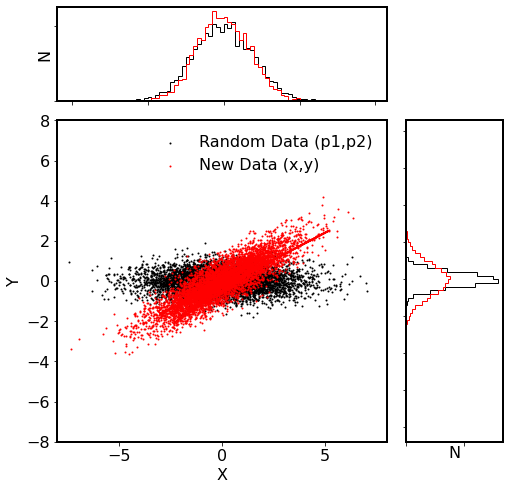

In [852]:
xy1 = [p1,p2]
xy2 = [x,y]
label1 = 'Random Data (p1,p2)'
label2 = 'New Data (x,y)'

print('x- and y-axis histograms of the marginal distributions of p1, p2, x, and y')

PlotTwoDist(xy1, xy2, label1, label2, 10, addgauss=False, gxsig=False, gysig=False, connect=20)


Marginal Distributions of P1,P2 are Guassian with expected values


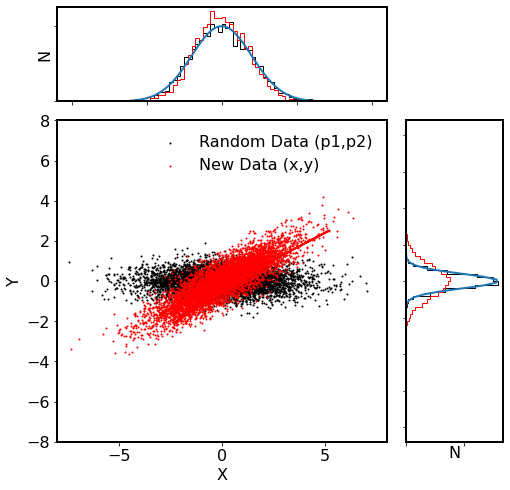

In [845]:
print('Marginal Distributions of P1,P2 are Guassian with expected values')
PlotTwoDist(xy1, xy2, label1, label2, 10, addgauss=True, gxsig=2, gysig=0.5, connect=20)

#### Answer

To compute the expected values of  $\sigma_x$, $\sigma_y$, and $\sigma_{xy}$, I used the equations suggested, where $\sigma_1 = 2$, $\sigma_2 = 0.5$, and $\alpha = \frac{\pi}{6}$. 

$\sigma_x = \sqrt{\sigma_1^2 \cos\alpha^2 + \sigma_2^2 \sin\alpha^2} $

$\sigma_y = \sqrt{\sigma_1^2 \sin\alpha^2 + \sigma_2^2 \cos\alpha^2} $

$\sigma_{xy} = (\sigma_1^2 - \sigma_2^2) \sin\alpha \cos\alpha$

In the plot below, p1,p2, and x,y distributions are plotted over the top of each other and their marginal distributions are plotted as x and y axis histograms. These marginal distributions are fit with the expected widths calculated using the equations above for $\sigma_x and \sigma_y$. Therefore, as seen in the plot, the marginal distributions are infact Guassian with the expected widths shown with the overplot comparison of a Guassian (blue line over the (x,y) marginal distribution). 

The covariance matrix of (x,y) is ${\bf C} = \left({\sigma_x^2 \atop \sigma_{xy}} {\sigma_{xy} \atop \sigma_y^2}\right)$. The values calculated were ${\bf C} = \left({3.0625 \atop 1.62379763} {1.62379763 \atop 1.1875}\right)$. The second method for generating the (x,y) distribution is by using the function np.random.multivariate_normal() which takes in the expected covariance matrix and mean values. This method is much simpler and faster than generating random data pairs with the function np.random.normal() that uses a Gaussian of standard deviations $\sigma_1 = 2$ and $\sigma_2 = 0.5$ and a mean zero and then rotating them by $\alpha = \frac{\pi}{6}$. The last plot is of the two (x,y) distributions plotted over each other. The black (x,y) data plotted is from using np.random.normal() and the red (x,y) data plotted is from using the np.random.multivariate_normal() with the covariance matrix. From that plot you can see that the marginal distributions are still with good agreement with Gaussians (blue line).

Marginal Distributions of X,Y are Guassian with expected values


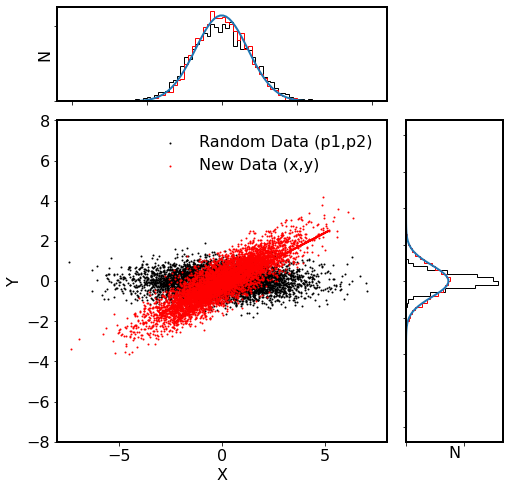

In [846]:
print('Marginal Distributions of X,Y are Guassian with expected values')
PlotTwoDist(xy1, xy2, label1, label2, 10, addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2), connect=20)

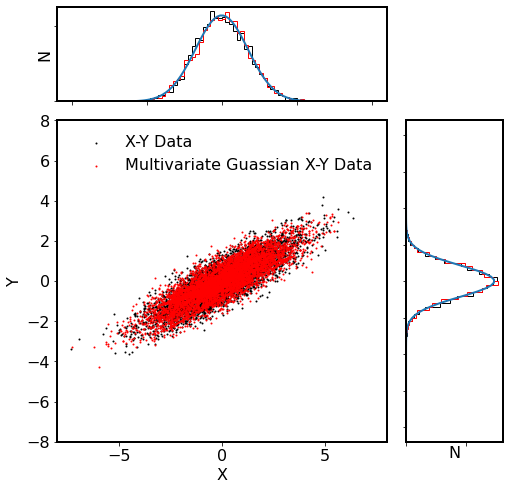

In [853]:
x2 = xy.T[0]
y2 = xy.T[1]
xy3 = [x,y]
xy4 = [x2,y2]
label1 = 'X-Y Data'
label3 = 'Multivariate Guassian X-Y Data'


PlotTwoDist(xy3, xy4, label1, label3, 10, addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2), connect=20)


## 2. MCMC realization of a 2-d probability distribution

The probability distribution for the bivariate Gaussian distribution in Part 1 is:
$$
p(\vec x) =  {1 \over 2\pi\sqrt{{\rm det}({\bf C})}}
  \exp\left(-{1\over 2} \vec x^T {\bf H} \vec x\right),
$$
where $\vec x=(x,y)$, ${\bf C} = \left({\sigma_x^2 \atop \sigma_{xy}} {\sigma_{xy} \atop \sigma_y^2}\right)$, and ${\bf H} = {\bf C}^{-1}$.

Implement a simple Markov Chain Monte Carlo (MCMC) routine:

1. Start at a user-specified location $x_0,y_0$.

2. At each iteration generate a trial point $(x_{i+1},y_{i+1})$ with
$$\eqalign{
x_{i+1}&=x_i + h\sigma_x {\cal N}(0,1)  \cr
y_{i+1}&=y_i + h\sigma_y {\cal N}(0,1)  \cr
}
$$
where ${\cal N}(0,1)$ is a Gaussian random variable of zero mean and unit dispersion (chosen separately for $x$ and $y$) and $h$ is a user-specified scaling of step size.

3. If $p(x_{i+1},y_{i+1}) > p(x_i,y_i)$ accept the step, i.e., add the new pair to the chain and take your next trial step from this new position.

4. If $p(x_{i+1},y_{i+1}) < p(x_i,y_i)$ then accept the step with probability $p(x_{i+1},y_{i+1})/p(x_i,y_i)$ (draw a uniform random deviate and compare it to this ratio).  If the step is not accepted, add the previous point ($x_i, y_i$) to the chain and generate a new trial point.

5. Output the final distribution of the chain.  Also keep track of and report the fraction of trial steps that are accepted, i.e., the ratio of the final length of the chain to the total number of steps needed to produce it.

In [881]:
# Starting point

# DHW mc2d.py, modified for notebook 

def MultiGaussProb(x,cinv,prefac):
    '''
    Return multivariate Gaussian probability
    x: vector of data values(matrix)
    cinv: inverse covariance matrix
    prefac:  prefactor for properly normalized Gaussian (float),
             taken as input so that it isn't computed every call
             should be [(2\pi)^{M/2} \sqrt{det(C)}]^{-1}
    '''
    arg = float(x * cinv * x.T)
    return (prefac * np.exp(-arg/2.))

def mcmc(xy_start, xy_step, nchain, nthin, seed, sig1=2, sig2=0.5):
    '''
    xy_start: [xstart, ystart]
    xy_step: [xstep, ystep]
    nchain: output chain length (after thinning)
    nthin: thinning factor
    '''
    np.random.random(seed)
    
    #nchain = 5000
    #nthin = 1
    #seed = 12
    # generate a chain nthin times longer than the final chain
    nchain = nthin * nchain    
    chain=np.zeros((nchain,3))    # store (x,y,p) as elements of chain
    
    mux = 0
    muy = 0
    alpha= np.pi/6
    cosa = np.cos(alpha)
    sina = np.sin(alpha)
    
    
    sigx = np.sqrt(((sig1**2)*(cosa**2))+((sig2**2)*(sina**2)))
    sigy = np.sqrt(((sig1**2)*(sina**2))+((sig2**2)*(cosa**2)))
    sigxy = (sig1**2-sig2**2)*sina*cosa
    cov = np.array([[sigx**2, sigxy], [sigxy, sigy**2]], dtype=float)
    prefac = ((2*np.pi)*np.sqrt(np.linalg.det(cov)))**(-1)
    cinv = np.linalg.inv(cov)
    x0 = xy_start[0]
    y0 = xy_start[1]
    
    prob1=MultiGaussProb(np.matrix([x0,y0]),cinv,prefac)
    #chain += [x0,y0,prob1]
    
    i = 0
    
    while i<nchain:
        
        x = x0 + xy_step[0]*np.random.normal(mux,sig1)
        y = y0 + xy_step[1]*np.random.normal(muy,sig2)
        prob1=MultiGaussProb(np.matrix([x0,y0]),cinv,prefac)
        prob2 = MultiGaussProb(np.matrix([x,y]),cinv,prefac)
        
        chain[-1] = [x,y,prob2]
        
        if prob2>prob1:
            chain[i] = [x,y,prob2]
            i +=1
            x0 = x
            y0 = y
                
        else:
            xtrial = np.random.uniform(low=0,high=1)
                
            if xtrial<(prob2/prob1):
                chain[i]=[x,y,prob2]
                i+=1
                x0 = x
                y0 = y  
                
            else:
                chain[i]=[x0,y0,prob1]
        
    # Output the chain 'thinned' by the factor nthin
    return chain, float(i/nchain)

### 2.1 Use this program to generate a 5000-element chain starting from $(x,y)=(1,1)$ with step scaling $h=1$.  

Plot the distribution of points from this chain, and the corresponding marginal distributions, over the bivariate Gaussian distribution from Part 1. If your programs are working, you should get good agreement.

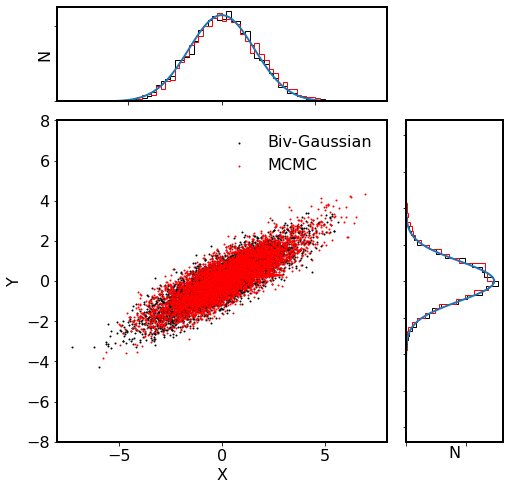

In [882]:
### Answer

xy_start = np.array([1.,1.])
xy_step = np.array([1.,1.])
chain1,frac_iter = mcmc(xy_start, xy_step, 5000, 1, 12)
x_mcmc=chain1.T[0]
y_mcmc=chain1.T[1]
xy_mcmc=[x_mcmc,y_mcmc]

# Illustration of how to use PlotTwoDist() -- 
PlotTwoDist(xy4,xy_mcmc, "Biv-Gaussian", "MCMC", 8,  addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2),connect=20)

### 2.2 Try several different starting points and compare the results. You can just describe this comparison in words. 

Starting points with a step size of 1

(x2,y2)=(0.5,0.5)

(x3,y3)=(0.05,0.05)

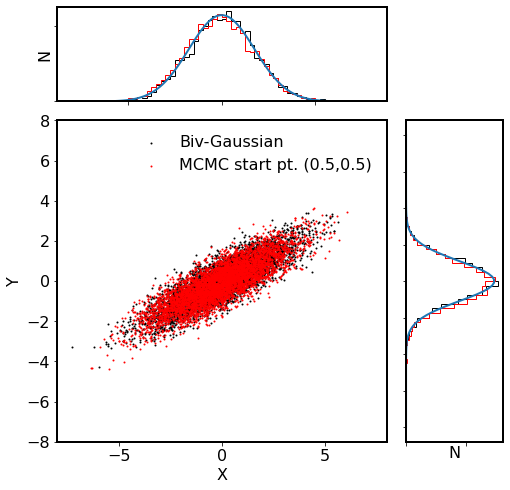

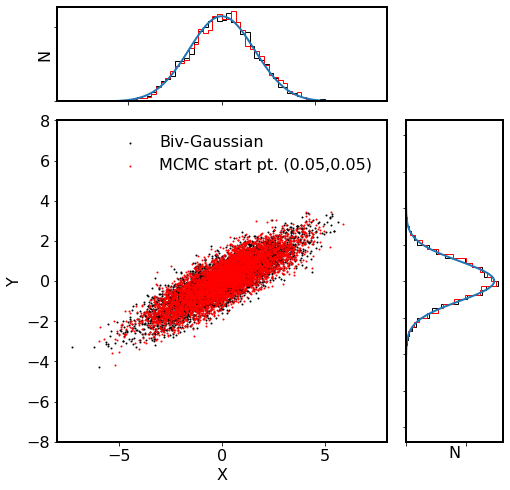

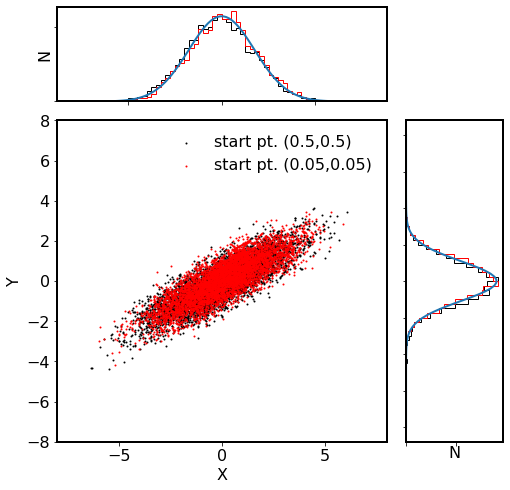

In [870]:
### Answer 

xy_step = np.array([1.,1.])

xy_start2 = np.array([0.5,0.5])
chain2,frac_iter2 = mcmc(xy_start2, xy_step, 5000, 1, 12)
x_mcmc2=chain2.T[0]
y_mcmc2=chain2.T[1]
xy_mcmc2=[x_mcmc2,y_mcmc2]

xy_start3 = np.array([0.05,0.05])
chain3,frac_iter3 = mcmc(xy_start3, xy_step, 5000, 1, 12)
x_mcmc3=chain3.T[0]
y_mcmc3=chain3.T[1]
xy_mcmc3=[x_mcmc3,y_mcmc3]

PlotTwoDist(xy4,xy_mcmc2, "Biv-Gaussian", "MCMC start pt. (0.5,0.5)", 8,  addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2),connect=20)
print()
PlotTwoDist(xy4,xy_mcmc3, "Biv-Gaussian", "MCMC start pt. (0.05,0.05)", 8,  addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2),connect=20)
print()
PlotTwoDist(xy_mcmc2,xy_mcmc3, "start pt. (0.5,0.5)", "start pt. (0.05,0.05)", 8,  addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2),connect=20)


### 2.2 Change h from 1 to 0.1 and plot the results. Compare the distribution to that for h = 1, and comment on the fraction of steps that are accepted.

Same Starting Point (x,y)=(1,1)

New Step Size h = 0.1 

(xstep,ystep)=(0.1,0.1)

1.0


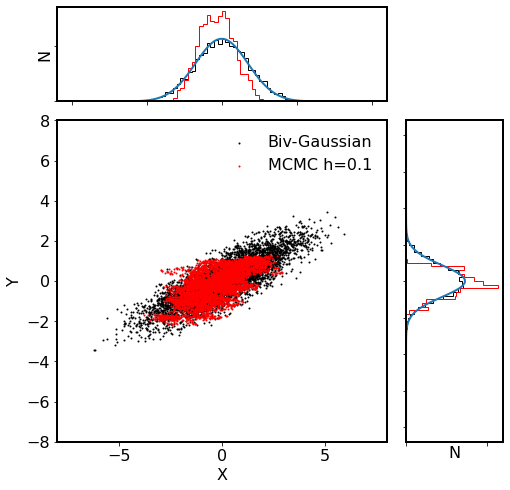

In [872]:
### Answer 
xy_start4 = np.array([1.,1.])
xy_step4 = np.array([0.1,0.1])
chain4,frac_iter4 = mcmc(xy_start4, xy_step4, 5000, 1, 12)
print(frac_iter4)
x_mcmc4=chain4.T[0]
y_mcmc4=chain4.T[1]
xy_mcmc4=[x_mcmc4,y_mcmc4]

xy_start0 = np.array([1.,1.])
xy_step0 = np.array([1.,1.])
chain0,frac_iter0 = mcmc(xy_start0, xy_step0, 5000, 1, 12)
x_mcmc0=chain0.T[0]
y_mcmc0=chain0.T[1]
xy_mcmc0=[x_mcmc0,y_mcmc0]

PlotTwoDist(xy_mcmc0,xy_mcmc4, "Biv-Gaussian", "MCMC h=0.1", 10,  addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2),connect=20)

### 2.3 Change h from 1 to 2.5. Compare the distribution to that for h = 1 (with a plot), and compare the fraction of steps that are accepted.

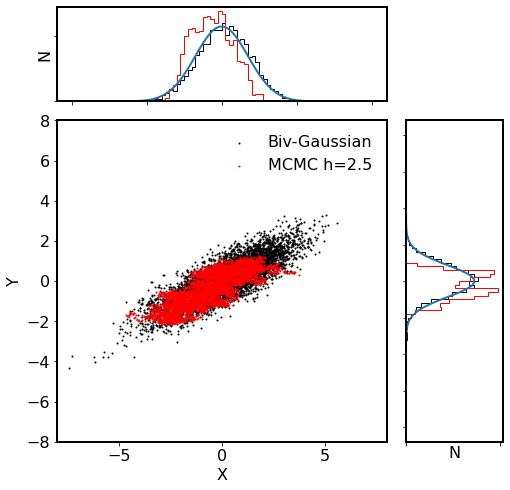

In [615]:
### Answer 
xy_start5 = np.array([1.,1.])
xy_step5 = np.array([2.5,2.5])
chain5,frac_iter5 = mcmc(xy_start5, xy_step5, 5000, 1, 12)
x_mcmc5=chain5.T[0]
y_mcmc5=chain5.T[1]
xy_mcmc5=[x_mcmc5,y_mcmc5]

xy_start0 = np.array([1.,1.])
xy_step0 = np.array([1.,1.])
chain0,frac_iter0 = mcmc(xy_start0, xy_step0, 5000, 1, 12)
x_mcmc0=chain0.T[0]
y_mcmc0=chain0.T[1]
xy_mcmc0=[x_mcmc0,y_mcmc0]

PlotTwoDist(xy_mcmc0,xy_mcmc4, "Biv-Gaussian", "MCMC h=2.5", 10,  addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2),connect=20)

### 2.4 Change $\sigma_2$ from 0.5 to 0.1. Compare to your previous results for h = 1.

1.0


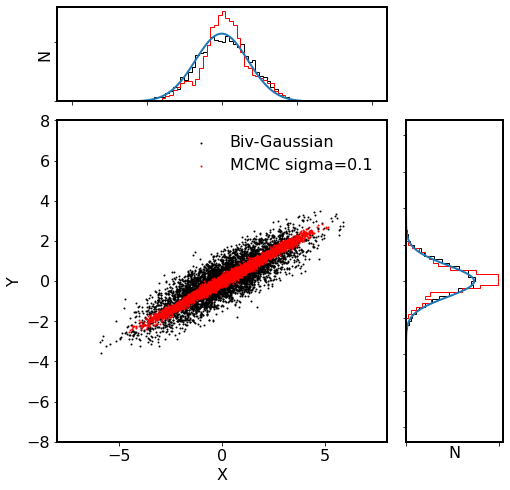

In [616]:
### Answer 
xy_start6 = np.array([1.,1.])
xy_step6= np.array([1.,1.])
chain6,frac_iter6 = mcmc(xy_start6, xy_step6, 5000, 1, 12,sig1=2, sig2=0.1)
print(frac_iter6)
x_mcmc6=chain6.T[0]
y_mcmc6=chain6.T[1]
xy_mcmc6=[x_mcmc6,y_mcmc6]

xy_start0 = np.array([1.,1.])
xy_step0 = np.array([1.,1.])
chain0,frac_iter0 = mcmc(xy_start0, xy_step0, 5000, 1, 12)
x_mcmc0=chain0.T[0]
y_mcmc0=chain0.T[1]
xy_mcmc0=[x_mcmc0,y_mcmc0]

sig1=2
sig2=0.1
sigx = np.sqrt(((sig1**2)*(cosa**2))+((sig2**2)*(sina**2)))
sigy = np.sqrt(((sig1**2)*(sina**2))+((sig2**2)*(cosa**2)))
sigxy = (sig1**2-sig2**2)*sina*cosa

PlotTwoDist(xy_mcmc0,xy_mcmc6, "sigma = 0.5", "MCMC sigma=0.1", 10,  addgauss=True, gxsig=np.sqrt(sigx2), gysig=np.sqrt(sigy2),connect=20)

### 2.5 Comment on issues of efficiency and accuracy in MCMC computations and strategies that could improve the efficiency for the $\sigma_2 = 0.1$ case.

### Answer



# 3. Cosmic MCMC: Parameters of the Universe

$\newcommand{\hubunits}{\,\hbox{km s$^{-1}$ Mpc$^{-1}$}}$

Here we will do a simplified version of the statistical analysis in Aubourg et al. (2015).

You may again use cosmodist_subs.py or astropy. If you used cosmodist_subs.py, use the (new) routine comsmodisth(), which returns different quantities than cosmodist(). In the latter case, I recommend adopting a tolerance of $3\times 10^{-5}$, which is adequate given the uncertainties of our observational constraints, and your code will evaluate this integral many times. 

This time, we will use its ability to compute distances for $\Omega_k \neq 0$  and $w=-1$.  Refer back to PS 3 for the relevant equations. 

As the cosmological constraints, take the following (the first two are from the CMB, and others are from BAO measurements):

$\Omega_m h^2 = 0.1386 \pm 0.0027.$

$D_M(z=1090) = 13962 \pm 10$ Mpc.

$D_M(z=2.34) = 5381 \pm 170$ Mpc.

$H(z=2.34) = 222 \pm 5 \hubunits.$

$D_M(z=0.57) = 2204 \pm 31$ Mpc.

$H(z=0.57) = 98 \pm 3 \hubunits.$

$D_M(z=0.32) = 1249 \pm 25$ Mpc.

Compute the likelihood of the data for a given set of cosmological parameters as $L \propto e^{-\chi^2/2}$, where $\chi^2$ is computed from the above data values ignoring any error covariances (i.e., $\chi^2 = \sum (y_i-y_{{\rm mod},i})^2/\sigma_i^2$). 

Adapt your MCMC code to create a chain for cosmological parameter values. You should set it up to allow steps in 4 parameters: $\Omega_m$, $h$, $w$, and $\Omega_k$. 

I recommend you write it to take as input a set of starting values (e.g. a dictionary called 'startvals') and a set of step sizes (e.g. a dictionary called 'stepvals'), and set the stepsize equal to zero for any parameter that should be held fixed. You should also use $e^{-\Delta\chi^2/2}$ to compute the ratio of the probabilities.

In [639]:
h0 = 70. 
om = 0.3
ok = 0. 
w = -1
zrec = 1090.
tcmb = 2.726

# Illustration of the use of cosmodist_subs -- 

import cosmodist_subs as cs

print("Timing of cs.cosmodisth()")
%timeit  cs.cosmodisth(1090, h0, om, ok, w)

[dmrec, hzrec] = cs.cosmodisth(1090, h0, om, ok, w)
print("cs.cosmodisth() =", dmrec, hzrec)

# Illustration of the use of astropy -- 

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=h0, Om0=om, Tcmb0=tcmb)

print("Timing of astropy.cosmology.FlatLambdaCDM")
%timeit FlatLambdaCDM(H0=h0, Om0=om, Tcmb0=tcmb), cosmo.comoving_distance(zrec).value, cosmo.H(zrec).value/h0

print("astropy output =", cosmo.comoving_distance(zrec).value, cosmo.H(zrec).value/h0)

print("Note the significant speed up with astropy!")

Timing of cs.cosmodisth()
1.49 ms ± 70.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
cs.cosmodisth() = 13615.917774798161 22594.79521294432
Timing of astropy.cosmology.FlatLambdaCDM
498 µs ± 30 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
astropy output = 13615.920554868035 22595.05201151454
Note the significant speed up with astropy!


In [889]:
# Starter code

# DHW cosmomc.py modified for notebook
def prob(model,data,errors):
    """
    Return e^{-chi^2/2}, for diagonal covariance matrix
    model = vector of model predictions
    data = vector of data values
    errors = vector of errors on data
    """
    dev = (model - data)/errors
    return (np.exp(-1.*sum(dev**2)/2.))

def modelvals(om,h,w,ok,astropy=True):
    """
    Return vector of the model predicted data values
    """
    omhsqr=om*(h**2)
    h0=100.*h                                   # value in km/s/Mpc
    if astropy: 
        cosmo = FlatLambdaCDM(H0=h0, Om0=om, Tcmb0=tcmb)
        [dmzrec,hzrec] = cosmo.comoving_distance(zrec).value, cosmo.H(zrec).value/h0
        [dmz234,hz234] = cosmo.comoving_distance(2.34).value, cosmo.H(2.34).value/h0
        [dmz057,hz057] = cosmo.comoving_distance(0.57).value, cosmo.H(0.57).value/h0
        [dmz032,hz032] = cosmo.comoving_distance(0.32).value, cosmo.H(0.32).value/h0       
    else: 
        [dmzrec,hzrec] = cs.cosmodisth(1090, h0, om, ok, w)
        [dmz234,hz234] = cs.cosmodisth(2.34, h0, om, ok, w)
        [dmz057,hz057] = cs.cosmodisth(0.57, h0, om, ok, w)
        [dmz032,hz032] = cs.cosmodisth(0.32, h0, om, ok, w)

    return (np.array([omhsqr,dmzrec,dmz234,hz234*h0,dmz057,hz057*h0,dmz032]))

def cosmomcmc(startvals, stepvals, nchain, nthin, seed, astropy=True):
    
    omstart = startvals['omega_m']
    hstart = startvals['H0']
    okstart = startvals['omega_k']
    wstart = startvals['w']
    
    omstep = stepvals['omega_m']
    hstep = stepvals['H0']
    okstep = stepvals['omega_k']
    wstep = stepvals['w']
    
    np.random.seed(seed)

    nchain = nchain * nthin     # number of elements needed for nchain outputs
    
    # data values and errors being used
    omhsqr=0.1386
    omhsqrerr=0.0027
    dmzrec=13962
    dmzrecerr=10
    dmz234=5381
    dmz234err=170
    hz234=222
    hz234err=5
    dmz057=2204
    dmz057err=31
    hz057=98
    hz057err=3
    dmz032=1249
    dmz032err=25

    data = np.array([omhsqr,dmzrec,dmz234,hz234,dmz057,hz057,dmz032])
    errors = np.array([omhsqrerr,dmzrecerr,dmz234err,hz234err,dmz057err,hz057err,dmz032err])

    # We are going to save all elements of the chain in memory to make
    # the i/o more efficient (one np.savetxt at the end), but if memory
    # were an issue we could write out steps one at a time (or in chunks)
    chain = np.zeros((nchain,5))
    chain[0][0] = om1 = omstart
    chain[0][1] = h1 = hstart
    chain[0][2] = w1 = wstart
    chain[0][3] = ok1 = okstart
    chain[0][4] = prob1  = prob(modelvals(omstart,hstart,wstart,okstart,astropy=True),data,errors)
    
    chain = chain[0]
    i = 0
    
    while i<nchain:
        
        n_om1 = omstart + omstep*np.random.normal(0,1)
        n_h1 = hstart + hstep*np.random.normal(0,1)
        n_w1 = wstart + wstep*np.random.normal(0,1)
        n_ok1 = okstart + okstep*np.random.normal(0,1)
        
        prob1 = prob(modelvals(omstart,hstart,wstart,okstart,astropy=True),data,errors)
        prob2 = prob(modelvals(n_om1,n_h1,n_w1,n_ok1,astropy=True),data,errors)
    
        if prob2>prob1:
            chain[i][0] = n_om1
            chain[i][1] = n_h1
            chain[i][2] = n_w1
            chain[i][3] = n_ok1
            chain[i][4] = prob2
            i +=1
            omstart = n_om1
            hstart = n_h1
            wstart = n_w1
            okstart = n_ok1
               
        else:
            if np.random.uniform(0,1)<(prob2/prob1):
            
                chain[i][0] = n_om1
                chain[i][1] = n_h1
                chain[i][2] = n_w1
                chain[i][3] = n_ok1
                chain[i][4] = prob2
                i+=1
                omstart = n_om1
                hstart = n_h1
                wstart = n_w1
                okstart = n_ok1
                
            else:
                chain[i][0] = omstart
                chain[i][1] = hstart
                chain[i][2] = wstart
                chain[i][3] = okstart
                chain[i][4] = prob1
        
    # Output the chain 'thinned' by the factor nthin
    return chain[::nthin], float(i/nchain)
        

### 3.1 Flat Universe

First consider a flat universe, with $\Omega_k=0$, but allowing free $w$. Create a 3-d MCMC chain using the parameters $\Omega_m$, $h$, and $w$, where $h \equiv H_0/100\hubunits$. Use your 4-d code but set the step size in the $\Omega_k$ dimension to zero. For a starting point I suggest $\Omega_m=0.3$, $h=0.68$, $w=-1$, and for initial step sizes I suggest trying $\Delta = 0.03$ in each parameter. 

I recommend you use a small (e.g. 2000) number of points for debugging and then a larger number (10-50k) when you are ready to make your final plot. 

Note that $\Delta$ here refers to the actual steps in $\Omega_m$, $h$, and $w$, and I have chosen it because I know
that these data give parameter errors that are roughly in this ballpark. Do not further multiply 0.03 by the expected standard deviations of these parameters --- that would be like taking $h=0.03$ in Part 2, and you already saw (I hope) that $h=0.1$ leads to chains that don't explore the likelihood surface very well.  I warn you in advance that with $\Delta = 0.03$ your acceptance fraction in the MCMC will be low ($\sim 1\%$), but if you take a much smaller step then you will not get good likelihood sampling.

Plot the distribution of your points in the planes $w$ vs. $\Omega_m$, $w$ vs. $h$, and $\Omega_m$ vs. $h$ with [corner.py](https://corner.readthedocs.io/en/latest/).

For reference, you may want to look at Figure 8 of Aubourg et al. (the $w$CDM panel for 3.1 and the o$\Lambda$CDM panel for 3.2), but you shouldn't expect to get exactly the same results. The main simplifications are that you are not including covariances of the errors and that I have converted the BAO measurements to absolute units using the best-fit value of the sound horizon $r_d$, which is well known (to 0.4\%) but not perfectly known; a full calculation would consider its dependence on cosmological parameters.

In [ ]:
startvals = dict()
startvals['omega_m'] = 0.3
startvals['H0'] = 0.68
startvals['omega_k'] = 0.
startvals['w'] = -1.

stepvals = dict()
stepvals['omega_m'] = 0.03
stepvals['H0'] = 0.03
stepvals['omega_k'] = 0.0 # hold fixed
stepvals['w'] = 0.03

c_chain31,frac_iter = cosmomcmc(startvals, stepvals, nchain=50000, nthin=1, seed=12, astropy=True)
#c_chain31 = cosmomcmc(startvals, stepvals, nchain=5000, nthin=50, seed=12, astropy=False)

In [ ]:
# Create the corner plot

# Illustration of how to use corner()
corner_input31 = c_chain31.T[0:3].T
figure = corner.corner(corner_input31, labels=[r"$\Omega_m$", r"$h$", r"$w$"],
                       quantiles=[0.5], 
                       show_titles=True, title_kwargs={"fontsize": 14}, title_fmt='.2f',
                       label_kwargs={"fontsize": 14},
                       hist2d_kwargs={"plot_contours": False, "plot_density": False}
                       )

### 3.2 Lambda Universe

Now consider a universe, with $w=-1$ and free $\Omega_k$. Create a 2000-point, 3-d MCMC using the parameters 
$\Omega_m$, $h$, and $\Omega_k$. (Set the step size in the $w$ dimension to zero.) I suggest you start with $\Omega_m=0.3$, $h=0.68$, $\Omega_k=0$, and for initial step sizes I suggest trying $\Delta = 0.03$ in the first two parameters and $\Delta = 0.003$ in $\Omega_k$.

Plot the distribution of your points in the planes $\Omega_k$ vs. $\Omega_m$, $\Omega_k$ vs. $h$, and $\Omega_m$ vs. $h$ with the corner module.

In [ ]:
### Answer 
startvals1 = dict()
startvals1['omega_m'] = 0.3
startvals1['H0'] = 0.68
startvals1['omega_k'] = 0.
startvals1['w'] = -1.

stepvals1 = dict()
stepvals1['omega_m'] = 0.03
stepvals1['H0'] = 0.03
stepvals1['omega_k'] = 0.003 # hold fixed
stepvals1['w'] = 0.0

c_chain3,frac_iter2 = cosmomcmc(startvals1, stepvals1, nchain=10000, nthin=1, seed=12, astropy=True)
#c_chain31 = cosmomcmc(startvals, stepvals, nchain=5000, nthin=50, seed=12, astropy=False)

In [ ]:
corner_input3 = c_chain3.T[0:3].T
figure = corner.corner(corner_input3, labels=[r"$\Omega_m$", r"$h$", r"$w$"],
                       quantiles=[0.5], 
                       show_titles=True, title_kwargs={"fontsize": 14}, title_fmt='.2f',
                       label_kwargs={"fontsize": 14},
                       hist2d_kwargs={"plot_contours": False, "plot_density": False}
                       )